In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import time
from torchvision import datasets, transforms
from tensorboardX import SummaryWriter
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 64


# hard-code random seeds for deterministic outcomes
np.random.seed(42)
torch.manual_seed(42)


In [2]:
# loading the dataset
# note that this time we do not perfrom the normalization operation, see next cell
test_dataset = datasets.MNIST('mnist_data/', train=False, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc = nn.Linear(28*28, 200)
        self.fc2 = nn.Linear(200,10)

    def forward(self, x):
        x = x.view((-1, 28*28))
        x = F.relu(self.fc(x))
        x = self.fc2(x)
        return x

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(5, 5))
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(5, 5))
        self.bn2 = nn.BatchNorm2d(32)
        self.conv2_drop = nn.Dropout2d(p=0.2)
        self.fc1 = nn.Linear(128, 100)
        self.fc2 = nn.Linear(100, 10)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3, 3))
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=(3, 3))
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=(3, 3))
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=(1, 1))
        self.bn6 = nn.BatchNorm2d(128)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = self.conv2_drop(F.max_pool2d(self.bn2(x), 2))
        x = F.relu(self.conv3(x))
        x = self.bn3(x)
        x = F.relu(self.conv4(x))
        x = self.bn4(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2_drop(x)
        x = F.relu(self.conv5(x))
        x = self.bn5(x)
        x = F.relu(self.conv6(x))
        x = self.bn6(x)
        size = x.size()[1] * x.size()[2] * x.size()[3]
        # print(size)
        x = x.view(-1, size)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



class Normalize(nn.Module):
    def forward(self, x):
        return (x - 0.1307)/0.3081


In [4]:
# define a show function for later
def show(original, adv, model_to_prob):
    p0 = model_to_prob(original).detach().numpy()
    p1 = model_to_prob(adv).detach().numpy()
    f, axarr = plt.subplots(1, 2)
    
    axarr[0].imshow(original.detach().numpy().reshape(28, 28), cmap='gray')
    axarr[0].set_title("Original, class: " + str(p0.argmax()))
    axarr[1].imshow(adv.detach().numpy().reshape(28, 28), cmap='gray')
    axarr[1].set_title("Original, class: " + str(p1.argmax()))
    print("Class\t\tOrig\tAdv")
    
    for i in range(10):
        print("Class {}:\t{:.2f}\t{:.2f}".format(
            i, float(p0[:, i]), float(p1[:, i])))


In [5]:
"""Load the body of the pre-trained neural net"""
model = torch.load('model.net', map_location='cpu')

"""
Add data normalization as a first "layer" to the network
It allows us to search for adversarial examples to the real image, rather than to the normalized image.
"""
model = nn.Sequential(Normalize(), model)

"""
Create a version of the model that outputs the class probabilities
"""
model_to_prob = nn.Sequential(model, nn.Softmax())

"""
We put the NN into evaluation mode (this disables features like dropout)
"""
model.eval()
model_to_prob.eval()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/serialization.py:637: UserWarning: Couldn't retrieve source code for container of type ConvNet. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set 

Sequential(
  (0): Sequential(
    (0): Normalize()
    (1): ConvNet(
      (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
      (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2_drop): Dropout2d(p=0.2, inplace=False)
      (fc1): Linear(in_features=128, out_features=100, bias=True)
      (fc2): Linear(in_features=100, out_features=10, bias=True)
      (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (bn5): BatchNorm2d(128, eps=1e-05, momentum=

In [6]:
# x: input image
# target: target class
# eps: size of l-infinity ball
def fgsm_targeted(model, x, target, eps, **kwargs):
    return _fgsm(model, x, target, eps, targeted=True, **kwargs)


def fgsm_untargeted(model, x, label, eps, **kwargs):
    return _fgsm(model, x, label, eps, targeted=False, **kwargs)


def _fgsm(model, x, target, eps, targeted=True, clip_min=None, clip_max=None):
    """Internal process for all FGSM and PGD attacks"""

    # Create a copy of the input
    # Detach --> move to RAM
    input_ = x.clone().detach_()

    # Make sure we are differentiating toward that variable
    input_.requires_grad_()

    # Run the model and obtain the loss
    prediction = model(input_)
    
    # Transform target into PyTorch understandable type
    target = torch.LongTensor([target])
    
    # Initialize every gradient of every component to be 0 
    model.zero_grad()

    loss = nn.CrossEntropyLoss()(prediction, target)
    
    # Computes derivative w.r.t input for every parameter of input that has required gradient
    loss.backward()

    if targeted:
        modified_input = input_ - eps * input_.grad.sign()
    else:
        modified_input = input_ + eps * input_.grad.sign()

    # Clip the output back to the image value domain
    if clip_min or clip_max:
        modified_input.clamp_(min=clip_min, max=clip_max)

    return modified_input

In [7]:
def pgd(model, x, label, k, eps, eps_step, clip_min=None, clip_max=None):
    x_min = x - eps
    x_max = x + eps

    # Randomize the starting point x
    x = x + eps * (2 * torch.rand_like(x) - 1)

    if clip_min or clip_max:
        x.clamp(min=clip_min, max=clip_max)
    
    # Do GD update step
    for i in range(k):
        # Compute FGSM
        x = _fgsm(model, x, label, eps_step, targeted=False)
        
        # Project given value
        x = torch.max(x_min, x)
        x = torch.min(x_max, x)

    if clip_min or clip_max:
        x.clamp(min=clip_min, max=clip_max)

    return x

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Class		Orig	Adv
Class 0:	0.00	0.00
Class 1:	0.00	0.00
Class 2:	0.00	0.02
Class 3:	0.00	0.43
Class 4:	0.00	0.01
Class 5:	0.00	0.01
Class 6:	0.00	0.00
Class 7:	1.00	0.35
Class 8:	0.00	0.06
Class 9:	0.00	0.12


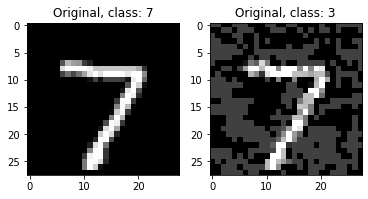

Class		Orig	Adv
Class 0:	0.00	0.00
Class 1:	0.00	0.00
Class 2:	0.00	0.01
Class 3:	0.00	0.80
Class 4:	0.00	0.00
Class 5:	0.00	0.01
Class 6:	0.00	0.00
Class 7:	1.00	0.15
Class 8:	0.00	0.02
Class 9:	0.00	0.01


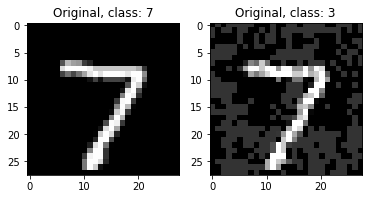

Class		Orig	Adv
Class 0:	0.00	0.00
Class 1:	0.00	0.00
Class 2:	0.00	0.00
Class 3:	0.00	1.00
Class 4:	0.00	0.00
Class 5:	0.00	0.00
Class 6:	0.00	0.00
Class 7:	1.00	0.00
Class 8:	0.00	0.00
Class 9:	0.00	0.00


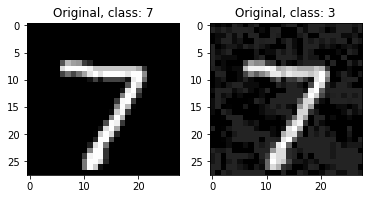

In [8]:
# Try out our attacks
original = torch.unsqueeze(test_dataset[0][0], dim=0)

# Untarget FGSM attack
adv = fgsm_untargeted(model, original, label=7, eps=0.25, clip_min=0, clip_max=1.0)
show(original, adv, model_to_prob)
plt.show()

# Target FGSM attack
adv = fgsm_targeted(model, original, target=3, eps=0.2, clip_min=0, clip_max=1.0)
show(original, adv, model_to_prob)
plt.show()

# PGD attack
adv = pgd(model, original, label=7, k=10, eps=0.08,
          eps_step=0.05, clip_min=0, clip_max=1.0)

show(original, adv, model_to_prob)
plt.show()